# Import Libraries

In [2]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge, LassoLars, BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from collections import Counter
from pandas.api.types import is_numeric_dtype
from scipy.stats import randint
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from enum import Enum
import numpy as np
import random

# Load Data

In [21]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",100)

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Preprocess Data

In [22]:
class ColumnInfo:
    def __init__(self, column, labels):
        self.column = column
        self.row_count = len(self.column)
        self.column_name = self.column.name
        self.data_type = self.column.dtype
        self.empty_values = self.column.isnull().sum()
        self.empty_perc = self.empty_values / self.row_count
        self.total_values = self.row_count - self.empty_values
        self.unique_values = self.column.nunique()
        self.unique_perc = self.unique_values / self.total_values
        self.corr_perc = 0
        self.feature_type = ""
        self.corr_threshold = 0.1
        self.unique_threshold = 0.02
        self.labels = labels

    
    def analyse(self):
        label_encoder = LabelEncoder()

        if is_numeric_dtype(self.column):
            self.corr_perc = self.column.corr(self.labels)

        # Work out whether the feature is numerical, categorical, ordinal or text
        if self.data_type == "float64":
            self.feature_type = "Numerical"
        elif self.unique_perc <= self.unique_threshold:
            if self.data_type == "object":
                object_labels = label_encoder.fit_transform(self.column.dropna())
                self.corr_perc = pd.DataFrame(object_labels)[0].corr(self.labels)

            if abs(self.corr_perc) >= self.corr_threshold:
                self.feature_type = "Ordinal"
            else:
                self.feature_type = "Categorical"

        elif self.data_type == "int64":
            self.feature_type = "Numerical"

        else:
            self.feature_type = "Text"

    def recommend(self):
        self.analyse()
        
        # Decide on what we should do with this feature
        if self.empty_perc > 0.2:
            self.recommend = "Drop"
        elif self.feature_type == "Numerical" and abs(self.corr_perc) < 0.05:
            self.recommend = "Drop"
        elif self.feature_type == "Categorical" or self.feature_type == "Ordinal":
            self.recommend = "One-Hot Encode"
        elif is_numeric_dtype(self.column):
            self.recommend = "Scale"
        else:
            self.recommend = "Drop"


In [23]:
class DataPreprocessor:
    def __init__(self, train, test, labels):
        self.train = train
        self.test = test
        self.labels = labels
        self.train_len = len(self.train)
        self.test_len = len(self.test)
        self.analysis_columns = ["Columns", "Data Type", "Unique Values", "Total Values", "Empty Values", 
                                 "Empty %", "Correlation %", "Feature Type"]
        
        self.recommend_columns = self.analysis_columns.copy()
        self.recommend_columns.append("Recommend")
        
        self.action_columns = self.analysis_columns.copy()
        self.action_columns.append("Action")
        
    def analyse(self):
        analysisTable = pd.DataFrame(columns=self.analysis_columns)

        count = 0
        
        for i in self.train:
            column_info = ColumnInfo(self.train[i], self.labels)
            column_info.analyse()
            
            analysisTable.loc[i] = [
                column_info.column_name,
                column_info.data_type,
                column_info.unique_values,
                column_info.total_values,
                column_info.empty_values,
                column_info.empty_perc,
                column_info.corr_perc,
                column_info.feature_type
            ]
            
            count += 1

        return analysisTable
    
    def recommend(self):
        recommend_table = pd.DataFrame(columns=self.recommend_columns)

        count = 0
        
        for i in self.train:
            column_info = ColumnInfo(self.train[i], self.labels)
            column_info.recommend()
            
            recommend_table.loc[i] = [
                column_info.column_name,
                column_info.data_type,
                column_info.unique_values,
                column_info.total_values,
                column_info.empty_values,
                column_info.empty_perc,
                column_info.corr_perc,
                column_info.feature_type,
                column_info.recommend
            ]
            
            count += 1

        return recommend_table
    
    def action(self):
        action_table = pd.DataFrame(columns=self.action_columns)
        finalTable = np.zeros(shape=(self.train_len + self.test_len,))
        data_process = self.train.append(self.test)

        binarizer = LabelBinarizer()
        scaler = StandardScaler()

        count = 0
        
        for i in self.train:
            column_info = ColumnInfo(self.train[i], self.labels)
            column_info.recommend()
            
            # Process the column (if it's not being dropped)
            action = column_info.recommend
            value = ""
            col_process = data_process[i]

            if action == "One-Hot Encode":
                col_process.fillna(col_process.value_counts().idxmax(), inplace=True)

                one_hot = binarizer.fit_transform(col_process)

                category_compare = pd.DataFrame(one_hot)
                value = np.zeros(shape = (self.train_len + self.test_len,))

                for cat in category_compare:
                    encoded_cat = category_compare[cat]
                    cat_corr = encoded_cat.corr(self.labels)

#                     if np.abs(cat_corr) > 0.05:
                    
                    value = np.c_[value, encoded_cat]

#                 if np.ndim(value) <= 1:
#                     analysisTable["Category Relevant"][count] = "No"
#                     analysisTable["Decision"][count] = "Drop"
#                     action = "Drop"
#                 else:
#                     analysisTable["Category Relevant"][count] = "Yes"

            elif action == "Scale":
                col_process.fillna(col_process.mean(), inplace=True)

    #             skewed_value = skew(col_process)

    #             if skewed_value > 0.75:
    #                 col_process = np.log1p(col_process)

                value = scaler.fit_transform(col_process.values.reshape(-1, 1))

            if action != "Drop":
                finalTable = np.c_[finalTable, value]
                
            action_table.loc[i] = [
                column_info.column_name,
                column_info.data_type,
                column_info.unique_values,
                column_info.total_values,
                column_info.empty_values,
                column_info.empty_perc,
                column_info.corr_perc,
                column_info.feature_type,
                column_info.recommend
            ]
            
            count += 1

        return action_table, finalTable[:self.train_len], finalTable[self.train_len:]


In [24]:
y = np.log(train_data["SalePrice"])
X = train_data.drop(labels="SalePrice", axis=1)
X_test = test_data

# analysis = DataPreprocessor(X, X_test, y).analyse()
# analysis = DataPreprocessor(X, X_test, y).recommend()
analysis, X, X_test = DataPreprocessor(X, X_test, y).action()
analysis

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Columns,Data Type,Unique Values,Total Values,Empty Values,Empty %,Correlation %,Feature Type,Action
Id,Id,int64,1460,1460,0,0.000000,-0.017942,Numerical,Drop
MSSubClass,MSSubClass,int64,15,1460,0,0.000000,-0.073959,Categorical,One-Hot Encode
MSZoning,MSZoning,object,5,1460,0,0.000000,-0.188860,Ordinal,One-Hot Encode
LotFrontage,LotFrontage,float64,110,1201,259,0.177397,0.355878,Numerical,Scale
LotArea,LotArea,int64,1073,1460,0,0.000000,0.257320,Numerical,Scale
Street,Street,object,2,1460,0,0.000000,0.057369,Categorical,One-Hot Encode
Alley,Alley,object,2,91,1369,0.937671,0.000000,Text,Drop
LotShape,LotShape,object,4,1460,0,0.000000,-0.278091,Ordinal,One-Hot Encode
LandContour,LandContour,object,4,1460,0,0.000000,0.032340,Categorical,One-Hot Encode
Utilities,Utilities,object,2,1460,0,0.000000,-0.012632,Categorical,One-Hot Encode


In [25]:
class ModelWrapper:
    def __init__(self, name, model, model_type):
        self.name = name
        self.model = model
        self.model_type = model_type
        self.cv_score = 0
        self.mean_cv_score = 0
        self.training_score = 0
        self.model_score = 0
        self.selected = False
        self.predictions = None
        
    def evaluate(self, X, y):
        self.cv_score = cross_val_score(self.model, X, y, cv = 5)
        self.mean_cv_score = np.mean(self.cv_score)
        self.model.fit(X, y)
        self.training_score = self.model.score(X, y)
        
    def process_results(self, X, y):
        print("======================================================================================")
        print(self.name)
        self.evaluate(X, y)
        print("Cross validation scores:", self.cv_score)
        print("Mean cross validation score:", self.mean_cv_score)
        print("Score on training set:", self.training_score)

class ModelType(Enum):
    Linear = 1
    Ensemble = 2

In [26]:
random_state = 23

models = []

# Linear models
models.append(ModelWrapper("ElasticNet", ElasticNet(alpha=0.001, random_state = random_state), ModelType.Linear))
models.append(ModelWrapper("Lasso", Lasso(alpha=0.001, random_state = random_state), ModelType.Linear))
models.append(ModelWrapper("Ridge", Ridge(random_state = random_state), ModelType.Linear))
models.append(ModelWrapper("KernelRidge", KernelRidge(alpha = 0.001), ModelType.Linear))
models.append(ModelWrapper("LassoLars", LassoLars(alpha = 0.001), ModelType.Linear))
models.append(ModelWrapper("BayesianRidge", BayesianRidge(), ModelType.Linear))
models.append(ModelWrapper("PassiveAggressiveRegressor", PassiveAggressiveRegressor(random_state = random_state, max_iter=1000), ModelType.Linear))

# Ensemble models
models.append(ModelWrapper("RandomForestRegressor", RandomForestRegressor(random_state = random_state), ModelType.Ensemble))
models.append(ModelWrapper("GradientBoostingRegressor", GradientBoostingRegressor(random_state = random_state), ModelType.Ensemble))
models.append(ModelWrapper("XGBRegressor", XGBRegressor(seed = random_state), ModelType.Ensemble))
models.append(ModelWrapper("ExtraTreesRegressor", ExtraTreesRegressor(random_state = random_state), ModelType.Ensemble))
models.append(ModelWrapper("BaggingRegressor", BaggingRegressor(random_state = random_state), ModelType.Ensemble))

for model in models:
    model.process_results(X, y) 


ElasticNet
Cross validation scores: [ 0.9242131   0.87674081  0.90386475  0.90336631  0.76705529]
Mean cross validation score: 0.875048052965
Score on training set: 0.925199109341
Lasso
Cross validation scores: [ 0.92460782  0.87240329  0.90699473  0.8979214   0.75960747]
Mean cross validation score: 0.872306944268
Score on training set: 0.910850387017
Ridge
Cross validation scores: [ 0.90772701  0.86983676  0.87456632  0.89207027  0.75927306]
Mean cross validation score: 0.860694684467
Score on training set: 0.94617219392
KernelRidge
Cross validation scores: [ 0.83685458  0.8464991   0.78501926  0.87582327  0.75172349]
Mean cross validation score: 0.819183939395
Score on training set: 0.952705941166
LassoLars
Cross validation scores: [ 0.85034718  0.80105934  0.82731559  0.82380096  0.68799997]
Mean cross validation score: 0.79810460856
Score on training set: 0.812496614978
BayesianRidge


C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=1.071e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=1.003e-03, with an active set of 27 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:313: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=1.375e-03, with an active set of 16 regressors, and the smallest cholesky pi

Cross validation scores: [ 0.91249206  0.8703503   0.89283744  0.89386243  0.77562977]
Mean cross validation score: 0.869034398982
Score on training set: 0.935383362195
PassiveAggressiveRegressor
Cross validation scores: [ 0.81725639  0.79457344  0.77884393  0.84265617  0.77469701]
Mean cross validation score: 0.801605388469
Score on training set: 0.93998433396
RandomForestRegressor
Cross validation scores: [ 0.85725958  0.83977181  0.84203088  0.84581265  0.84614601]
Mean cross validation score: 0.8462041851
Score on training set: 0.9719806534
GradientBoostingRegressor
Cross validation scores: [ 0.89858203  0.88220894  0.88198855  0.90279629  0.89503066]
Mean cross validation score: 0.892121293736
Score on training set: 0.955272349734
XGBRegressor
Cross validation scores: [ 0.90264128  0.87734833  0.88534257  0.88990216  0.88456185]
Mean cross validation score: 0.887959239485
Score on training set: 0.950406813286
ExtraTreesRegressor
Cross validation scores: [ 0.84186407  0.80494766  0

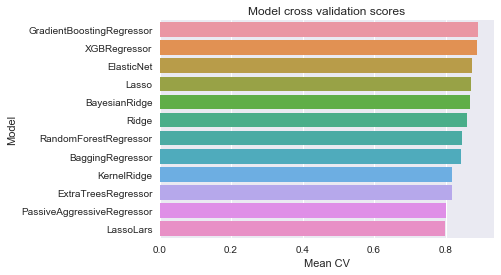

In [27]:
# Convert list of models to a pandas dataframe
chart_df = pd.DataFrame([vars(m) for m in models])
chart_df = chart_df.sort_values("mean_cv_score", ascending=False)

# Draw chart
chart = sns.barplot("mean_cv_score", "name", data = chart_df, orient = "h")
chart.set_xlabel("Mean CV")
chart.set_ylabel("Model")
chart.set_title("Model cross validation scores")

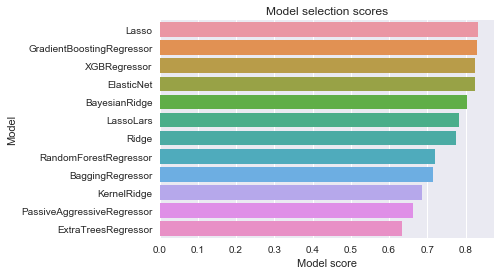

In [28]:
# Evaluate best models by penalising models that overfit
for model in models:
    model.model_score = model.mean_cv_score - (model.training_score - model.mean_cv_score)

# Convert list of models to a pandas dataframe
chart_df = pd.DataFrame([vars(m) for m in models])
chart_df = chart_df.sort_values("model_score", ascending=False)

# Draw chart
chart = sns.barplot("model_score", "name", data = chart_df, orient = "h")
chart.set_xlabel("Model score")
chart.set_ylabel("Model")
chart.set_title("Model selection scores")

In [29]:
for model in models:
    model.predictions = model.model.predict(X_test)
    model.predictions = np.exp(model.predictions)


In [30]:
model_df = pd.DataFrame([vars(m) for m in models])
model_df = model_df.sort_values("model_score", ascending=False)

model_weight = len(model_df) - 1
prediction_values = []
prediction_scores = []

for index, row in model_df.iterrows():
    prediction_values.append(row["predictions"])
    prediction_scores.append(row["model_score"] + (model_weight * 0.05))
    model_weight -= 1
    
prediction_weights = (np.array(prediction_scores) - min(prediction_scores))
prediction_weights = prediction_weights / sum(prediction_weights)
predictions = 0.

for i in range(len(prediction_weights)):
    predictions += prediction_weights[i] * prediction_values[i]

submission = pd.DataFrame({ "Id": test_data["Id"] })
submission["SalePrice"] = predictions

submission.to_csv("_dave_submit.csv", index=False)

print(prediction_weights)

[ 0.15661855  0.14517567  0.13401153  0.1234413   0.10836083  0.09395674
  0.08174071  0.05985676  0.04853984  0.03171265  0.01658541  0.        ]


In [31]:
predictions

array([ 123744.38213577,  148611.60441703,  185427.29367369, ...,
        158239.58573941,  121225.67296821,  225043.64840459])